In [45]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('billing_sm.csv')
df_r = pd.read_csv('reseller_sm.csv')

In [3]:
df['date'] = pd.to_datetime(df['date'])

In [4]:
# Filter Last 4 Months

In [5]:
max_date = df['date'].max()
min_date = max_date - pd.to_timedelta(120, unit='d')
df = df[df['date'] > min_date]

In [6]:
def completeItem(dfItem):
    min_date = dfItem['date'].min()
    max_date = dfItem['date'].max()
    if min_date == max_date:
        #only one data point
        return
    r = pd.date_range(start=min_date, end=max_date)
    dfItemNew = dfItem.set_index('date').reindex(r).rename_axis('date').reset_index()
    
    dfItemNew['mean-last-30'] = dfItemNew['bill'].rolling(30,min_periods=1).mean().reset_index()['bill']
    dfItemNew['mean-last-7'] = dfItemNew['bill'].rolling(7,min_periods=1).mean().reset_index()['bill']
    dfItemNew['std-last-30'] = dfItemNew['bill'].rolling(30,min_periods=1).std().reset_index()['bill']
    dfItemNew['bill'] = dfItemNew['bill'].fillna(0)
    dfItemNew['id_reseller'] = dfItem['id_reseller'].max()
    dfItemNew['std-last-30'].fillna(method='ffill',inplace=True)
    dfItemNew['mean-last-7'].fillna(method='ffill',inplace=True)
    dfItemNew['std-last-30'].fillna(method='ffill',inplace=True)
    resp = []
    counter = 0
    for index,row in dfItemNew.iterrows(): 
        resp.append(counter)
        if row['bill'] == 0: 
            counter += 1 
        else:
            counter = 0
    dfItemNew['days_without_purchase'] = pd.Series(resp)
    return dfItemNew

In [7]:
i = 0
dfCompletedList = []
for nid,item in df.groupby('id_reseller'):
    i = i+1
    if i%200 == 0:
        print ('processed {} resellers'.format(str(i)))
    dfCompletedList.append(completeItem(item))

processed 200 resellers
processed 400 resellers
processed 600 resellers
processed 800 resellers
processed 1000 resellers
processed 1200 resellers
processed 1400 resellers
processed 1600 resellers
processed 1800 resellers
processed 2000 resellers
processed 2200 resellers
processed 2400 resellers
processed 2600 resellers
processed 2800 resellers
processed 3000 resellers
processed 3200 resellers
processed 3400 resellers
processed 3600 resellers
processed 3800 resellers
processed 4000 resellers
processed 4200 resellers
processed 4400 resellers
processed 4600 resellers
processed 4800 resellers
processed 5000 resellers
processed 5200 resellers
processed 5400 resellers
processed 5600 resellers
processed 5800 resellers
processed 6000 resellers
processed 6200 resellers
processed 6400 resellers
processed 6600 resellers
processed 6800 resellers
processed 7000 resellers
processed 7200 resellers
processed 7400 resellers
processed 7600 resellers
processed 7800 resellers
processed 8000 resellers
proc

In [8]:
df = pd.concat(dfCompletedList).copy()
del dfCompletedList
df['weekday']  = df['date'].dt.weekday_name


In [9]:
df['next_bill'] = df.replace(0,np.nan).groupby('id_reseller')['bill'].fillna(method='bfill')

In [10]:
df['last_bill'] = df.replace(0,np.nan).groupby('id_reseller')['bill'].fillna(method='ffill').copy()
different_zero = df['last_bill'].shift(1)
df.loc[df['bill'] != 0,'last_bill'] = np.nan
df['last_bill'] = df['last_bill'].fillna(different_zero)

In [11]:
df.head()

,date,id_reseller,bill,mean-last-30,mean-last-7,std-last-30,days_without_purchase,weekday,next_bill,last_bill
0,2019-01-23,499921233,127180.938,127180.938,127180.938,NaN,0,Wednesday,127180.938,NaN
1,2019-01-24,499921233,0.000,127180.938,127180.938,NaN,0,Thursday,335067.312,127180.938
2,2019-01-25,499921233,0.000,127180.938,127180.938,NaN,1,Friday,335067.312,127180.938
3,2019-01-26,499921233,0.000,127180.938,127180.938,NaN,2,Saturday,335067.312,127180.938
4,2019-01-27,499921233,0.000,127180.938,127180.938,NaN,3,Sunday,335067.312,127180.938


In [12]:
df.shape

(1442916, 10)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1442916 entries, 0 to 62
Data columns (total 10 columns):
date                     1442916 non-null datetime64[ns]
id_reseller              1442916 non-null int64
bill                     1442916 non-null float64
mean-last-30             1442850 non-null float64
mean-last-7              1442916 non-null float64
std-last-30              1399292 non-null float64
days_without_purchase    1442916 non-null int64
weekday                  1442916 non-null object
next_bill                1442916 non-null float64
last_bill                1442915 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(2), object(1)
memory usage: 161.1+ MB


In [14]:
df = df.dropna().copy()

In [15]:
#We meassure success computing how many resellers did we predict with less than 15% error.
def score_15(y,preds):
    return np.sum(np.abs((preds-y)/y) <= 0.15 )/ len(preds)

In [16]:
score_15(df['next_bill'],df['last_bill'])

0.2249318910141878

In [17]:
df = pd.concat([df,pd.get_dummies(df.weekday)],axis=1)

In [18]:
val_resellers = list(pd.Series(df['id_reseller'].unique()).sample(frac=0.1))
df_train = df[~df['id_reseller'].isin(val_resellers)].sample(frac=1)
df_validation = df[df['id_reseller'].isin(val_resellers)].sample(frac=1)

In [19]:
df_train.head()

,date,id_reseller,bill,mean-last-30,mean-last-7,std-last-30,days_without_purchase,weekday,next_bill,last_bill,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
7,2019-01-30,500660164,3354.320,5255.316000,6000.2975,2943.839200,3,Wednesday,3354.320,8646.275,0,0,0,0,0,0,1
109,2019-05-15,500648583,0.000,2604.901800,3666.6830,1239.556650,3,Wednesday,2469.579,3666.683,0,0,0,0,0,0,1
113,2019-05-15,500798770,4094.552,5312.679278,6696.4914,1887.185147,0,Wednesday,4094.552,5476.415,0,0,0,0,0,0,1
81,2019-04-15,500743724,15325.084,9618.951571,10585.4625,4098.601953,3,Monday,15325.084,5845.841,0,1,0,0,0,0,0
108,2019-05-10,500647981,10327.414,7801.842778,6814.2790,3662.590534,2,Friday,10327.414,3301.144,1,0,0,0,0,0,0


In [20]:
df_train.columns

Index(['date', 'id_reseller', 'bill', 'mean-last-30', 'mean-last-7',
       'std-last-30', 'days_without_purchase', 'weekday', 'next_bill',
       'last_bill', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday'],
      dtype='object')

In [23]:
X_train = df_train[['mean-last-30', 'mean-last-7',
       'std-last-30', 'days_without_purchase','last_bill', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday']]

In [31]:
y_train = df_train['next_bill']

In [26]:
X_test = df_validation[['mean-last-30', 'mean-last-7',
       'std-last-30', 'days_without_purchase','last_bill', 'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday',
       'Tuesday', 'Wednesday']]

In [27]:
y_test = df_validation['next_bill']

In [37]:
model = RandomForestRegressor(n_estimators=40)

In [38]:
model.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [39]:
preds = model.predict(X_test)

In [40]:
score_15(y_test,preds)

0.34994169784460866

In [41]:
model.feature_importances_

array([0.70628133, 0.05527272, 0.12887755, 0.01563113, 0.07553195,
       0.0023554 , 0.00194502, 0.00267719, 0.00309889, 0.0023899 ,
       0.00261552, 0.00332341])

([<matplotlib.axis.YTick at 0x7f86c47645f8>,
 <a list of 12 Text yticklabel objects>)

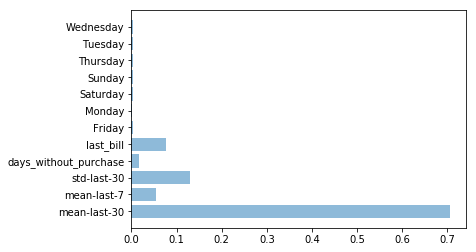

In [49]:
objects = X_train.columns
y_pos = np.arange(len(objects))
performance = model.feature_importances_

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)